#The Effect of Monetary Policy in the European Union since 1995

August 2015

Written by Susan Chen at NYU Stern with help from Professor David Backus

Contact: <jiachen2017@u.northwestern.edu>


This project was inspired by an IMF staff paper titled ["The Real Effects of Monetary Policy in the European Union: What are the Differences?"](https://www.imf.org/external/Pubs/FT/staffp/1998/06-98/pdf/ramaswam.pdf) by Ramana Ramaswamy and Torsten Sløk.

This paper examined the effects of monetary policy in the European Union using data from the period 1972-1995. Based on results from a vector autogression model, it was discovered that the European Union countries broadly fall into two groups in terms of how their output responds to a contractionary monetary shock. In one group (Austria, Belgium, Finland, Germany, the Netherlands, and the United Kingdom), the effects take 11 to 12 quarters to occur, whereas in the second (Denmark, France, Italy, Portugal, Spain, and Sweden), it is only 5 to 6 quarters. However, the effects in the former group are twice as severe as in the latter, with decline in output at 0.7-0.9 percent from the baseline in the former versus 0.4-0.6 percent in the latter. 

I wanted to pick up where the paper left off and examine what the effects of monetary policy have been like in the European Union since 1995, just a few years before the euro was introduced in 1999. Essentially, my project reverse engineers the results of this paper with the distinction of using data from 1995 to 2014. In addition, although several other countries have since been introduced into the EU, I chose to look at the same set of twelve countries in order to do a direct comparison and for sake of simplicity. 

##Abstract

In comparison to the estimations made in Ramaswamy and Sløk's paper, the results in my project indicate that since the introduction of the euro, the response of output in these EU countries to an interest rate shock has changed significantly. These countries no longer fall in the same two groups in terms of percent deviation from the baseline and amount of periods it takes for the effect to bottom out. 

In regards to percent deviation of output from the baseline, Austria, Belgium, Denmark, France, Germany, Italy, the Netherlands, Portugal, and the United Kingdom fall in the range 0.03 - 0.06 percent. Finland, Spain, and Sweden experience a higher deviation that falls in the 0.08 - 0.10 percent range. 

In regards to the amount of periods it takes for the monetary policy effect to bottom out, Austria, Belgium, Finland, Italy, Sweden, and the United Kingdom require 8 - 9 periods, while Denmark, France, Germany, the Netherlands, Portugal, and Spain require slightly more time at 10 - 12 periods. The differences between the number of periods here are almost negligible. 

In [916]:
import pandas as pd
import numpy as np
import statsmodels.tsa.api as tsa
import pandas.io.data as web
import datetime

#####Packages Imported

I use **pandas**, a Python package that allows for fast data manipulation and analysis. In pandas, a dataframe allows for storing related columns of data. I use **pandas.io.data** to extract data from FRED which is directly formatted into a dataframe. I also use **numpy**, a Python package for scientific computing, for the mathematical calculations that were needed to fit the data to a vector autoregression model. Lastly, I use **statmodels**, a Python module used for a variety of statistical computations, for creating a vector autoregression model. 

##Creating the Data Set 

Using the FRED api and data from the OECD website, I created a list of dataframes. Each dataframe contains a country's real GDP, CPI, and short-term interest rate. The code can be easily edited to include the exchange rate in the dataframes, which was done as an addition in the IMF paper. For now, I have chosen to exclude that portion from this project. Ramaswamy and Sløk's paper carry out the estimations both with and without the exchange rate in the VAR and found that its inclusion in the VAR largely did not change the results with the exception of Sweden where the response of output to an interest rate shock was dampened. 

In [898]:
#FRED Remote Data Access API for Real GDP data 

start = datetime.datetime(1995, 1, 1)
end = datetime.datetime(2014, 12, 30)

gdp=web.DataReader(['NAEXKP01FRQ189S','NAEXKP01ITQ189S','NAEXKP01DKQ189S','NAEXKP01SEQ652S','NAEXKP01ESQ652S','NAEXKP01PTQ652S','NAEXKP01DEQ189S','NAEXKP01NLQ189S','NAEXKP01BEQ189S','NAEXKP01ATQ189S','NAEXKP01FIQ189S','NAEXKP01GBQ652S'], 
"fred", start, end)

gdp.columns = ['France', 'Italy', 'Denmark', 'Sweden', 'Spain', 'Portugal', 'Germany', 'Netherlands', 'Belgium', 'Austria', 'Finland', 'United Kingdom']

In [899]:
#FRED Remote Data Access API for Exchange rate data 

exchange=web.DataReader(['CCUSMA02FRQ618N','CCUSMA02ITQ618N','CCUSMA02DKQ618N','CCUSMA02SEQ618N','CCUSMA02ESQ618N','CCUSMA02PTQ618N','CCUSMA02DEQ618N','CCUSMA02NLQ618N' ,'CCUSMA02BEQ618N', 'CCUSMA02ATQ618N','CCUSMA02FIQ618N','CCUSMA02GBQ618N'],
"fred", start, end)

exchange.columns = ['France', 'Italy', 'Denmark', 'Sweden', 'Spain', 'Portugal', 'Germany', 'Netherlands', 'Belgium', 'Austria', 'Finland', 'United Kingdom']

In [900]:
#Data downloaded from OECD and read into python using pandas

file1 = '/users/susan/desktop/cpiquarterlyoecd.csv' # file location #dates row replaced with a datetime format
cpi_df = pd.read_csv(file1) 
cpi_df = cpi_df.transpose() #OECD has years as columns and countries as rows 
cpi = cpi_df.drop(cpi_df.index[0]) #drop blank 'location' row
cpi.index = pd.to_datetime(cpi.index) #convert dates to datetime format
cpi.columns = ['Austria','Belgium','Czech Republic','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Ireland','Italy','Latvia','Luxembourg','Netherlands','Poland','Portugal','Slovak Republic','Slovenia','Spain','Sweden','United Kingdom']

file2 = '/users/susan/desktop/interestquarterlyoecd.csv' # file location
interest_df = pd.read_csv(file2)
interest_df = interest_df.transpose() #OECD has years as columns and countries as rows 
interest = interest_df.drop(interest_df.index[0]) #drop blank 'location' row
interest.index = pd.to_datetime(interest.index) #convert dates to datetime format
interest.columns = ['Austria','Belgium','Czech Republic','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Ireland','Italy','Latvia','Luxembourg','Netherlands','Poland','Portugal','Slovak Republic','Slovenia','Spain','Sweden','United Kingdom']

In [901]:
#Creating a list of dataframes organized by country 

by_country = {}

for country in gdp.columns:
    country_df = pd.concat([gdp[country], cpi[country], interest[country]], axis = 1) #add exchange[country] if including exchange rates
    country_df.columns = ['RealGDP', 'CPI', 'Interest'] #add 'Exchange' if necessary 
    country_df = country_df.convert_objects(convert_numeric = True)
    country_df = country_df.dropna()
    by_country[country] = country_df

##Dickey-Fuller test

To determine whether the data is non-stationary or not, I ran the Augmented Dickey-Fuller unit root test with a maximum of two lags and with constant and trend. In this test, the existence of a unit root, hence non-stationarity, is the null hypothesis. Critical values for the t-statistic are taken from MacKinnon (2010) {1%: -4.08, 5%: -3.47, 10%: -3.16}

We are unable to reject the null hypothesis based on the t-statistics for real GDP and CPI in all EU countries with the exception of Germany's real GDP given a 5% significance. Therefore, for the most part, the levels of both prices and output are nonstationary. 

Normally, taking the first difference of the data will yield stationarity. However, Ramaswamy and Sløk argue that there is a trade-off between statistical efficiency and potential loss of long-relationships among the variables when time series data is differenced. In addition, the impulse response of the first difference of output to an interest rates shock implies that monetary shocks have a permanent impact on the level of output. However, the impulse response of the level of output to an interest rate shock, past values of the variables determine whether a monetary shock is long lasting or not. For these reasons, I will be using the levels of the data as well. 

In [902]:
def fuller(country):
    for country in gdp.columns:
        print (country)    
        print ('Real GDP:' , (tsa.stattools.adfuller(by_country[country].RealGDP, maxlag = 2, regression = 'ct'))[0]) #prints the t-statistic
        print ('CPI:' , tsa.stattools.adfuller(by_country[country].CPI, maxlag = 2, regression = 'ct')[0])
        print ('Interest:' , tsa.stattools.adfuller(by_country[country].Interest, maxlag = 2, regression = 'ct')[0])
        print ('---')

fuller(country)

France
Real GDP: -1.71720663621
CPI: -1.96912370004
Interest: -3.69370462779
---
Italy
Real GDP: -1.59956078341
CPI: -2.8058842655
Interest: -3.24747445404
---
Denmark
Real GDP: -1.22841124218
CPI: -1.77422846528
Interest: -3.27697829313
---
Sweden
Real GDP: -2.59052137526
CPI: -3.19950183084
Interest: -5.41670459582
---
Spain
Real GDP: -1.94412770606
CPI: -1.88237597469
Interest: -3.73345933249
---
Portugal
Real GDP: -1.6624865835
CPI: -1.14543958354
Interest: -3.63092581462
---
Germany
Real GDP: -3.58588345908
CPI: -2.1602078014
Interest: -3.08632180489
---
Netherlands
Real GDP: -1.82123551358
CPI: -1.613602623
Interest: -3.12240272471
---
Belgium
Real GDP: -1.45026014742
CPI: -2.41193015183
Interest: -3.2334660222
---
Austria
Real GDP: -2.00285148874
CPI: -2.86811170598
Interest: -3.11550943059
---
Finland
Real GDP: -0.885032115833
CPI: -2.26965540322
Interest: -3.44863098069
---
United Kingdom
Real GDP: -2.0022697085
CPI: -1.02270243705
Interest: -3.15645327124
---


##Impulse Response Functions

Impulse response functions display the response of current and future values of each variable to a one unit increase in the current value of one of the VAR errors. This is done with the assumption that this error returns to zero in following periods and that all other errors are equal to zero. 

The impulse response functions are estimated with a three variable VAR, the variables being level of output, level of prices, and short term interest rates. I select the Bayesian information criterion (BIC) for VAR order selection because it returns the smallest number of lags in comparison with other information criterion. In addition, it yielded stable regression results. The number of lags for all countries is 2, with the exception of Denmark, which is 1. The impulse responses are estimated with the first 24 periods. We are focusing on the 'Interest -> Real GDP' graph which is interest rate shock on real GDP. 

In [903]:
def varmodel(country):
    mdata = by_country[country]
    data = np.log(mdata)
    model = tsa.VAR(data)
    res = model.fit(model.select_order()['bic'])
    irf = res.irf(24)
    irf.plot()
    #print (res.summary())  
    #print (res.is_stable())

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -13.87       -13.77    9.512e-07       -13.83
1        -25.25       -24.86    1.085e-11       -25.09
2        -25.78      -25.10*    6.380e-12      -25.51*
3        -25.71       -24.74    6.854e-12       -25.33
4        -25.54       -24.28    8.222e-12       -25.04
5        -25.71       -24.15    7.033e-12       -25.09
6        -25.79       -23.94    6.618e-12       -25.05
7        -25.92       -23.78    5.960e-12       -25.07
8        -25.85       -23.42    6.592e-12       -24.89
9        -26.20       -23.48   4.875e-12*       -25.12
10      -26.22*       -23.21    5.056e-12       -25.02
11       -26.03       -22.73    6.545e-12       -24.72
* Minimum



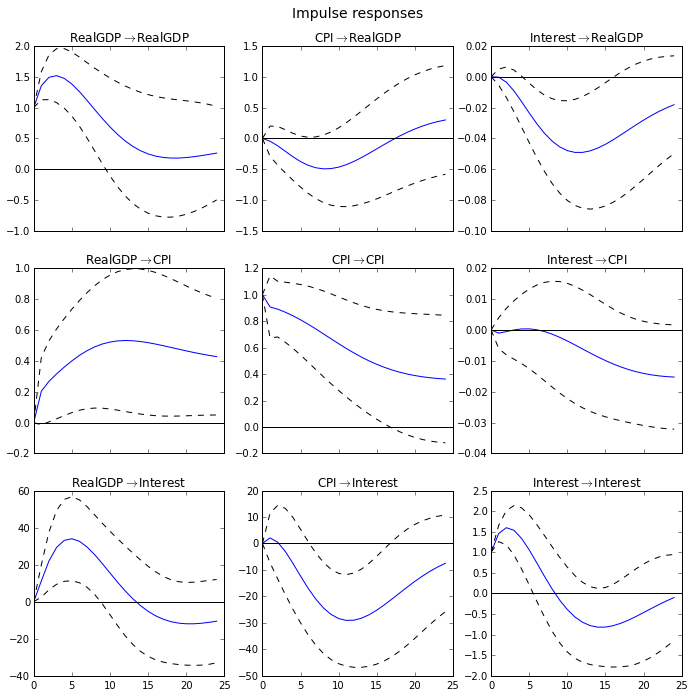

In [904]:
varmodel('France')

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -13.35       -13.25    1.590e-06       -13.31
1        -25.40       -25.00    9.309e-12       -25.24
2        -25.96      -25.26*    5.310e-12       -25.69
3        -26.15       -25.14    4.443e-12      -25.75*
4        -26.07       -24.77    4.833e-12       -25.56
5        -26.04       -24.43    5.065e-12       -25.41
6        -26.27       -24.36    4.115e-12       -25.52
7        -26.34       -24.13    3.960e-12       -25.47
8        -26.31       -23.80    4.262e-12       -25.32
9        -26.63       -23.82    3.262e-12       -25.52
10       -26.75       -23.64    3.092e-12       -25.53
11      -27.00*       -23.59   2.647e-12*       -25.66
* Minimum



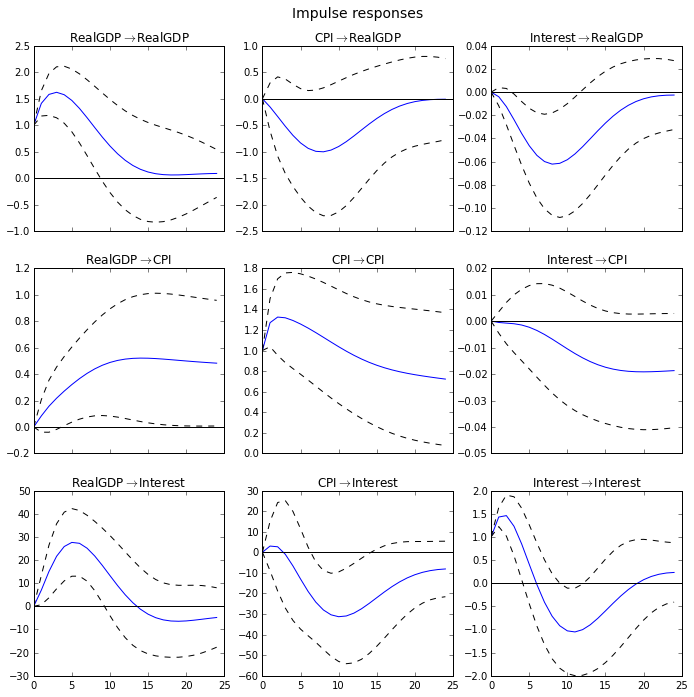

In [905]:
varmodel('Italy')

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -13.09       -12.99    2.064e-06       -13.05
1        -24.21      -23.82*    3.058e-11      -24.06*
2        -24.19       -23.51    3.120e-11       -23.92
3        -24.15       -23.18    3.255e-11       -23.77
4        -24.12       -22.86    3.388e-11       -23.62
5        -24.49       -22.94    2.363e-11       -23.88
6       -24.55*       -22.70   2.285e-11*       -23.81
7        -24.38       -22.25    2.756e-11       -23.54
8        -24.37       -21.95    2.881e-11       -23.41
9        -24.38       -21.66    2.995e-11       -23.30
10       -24.35       -21.34    3.277e-11       -23.15
11       -24.42       -21.12    3.274e-11       -23.11
* Minimum



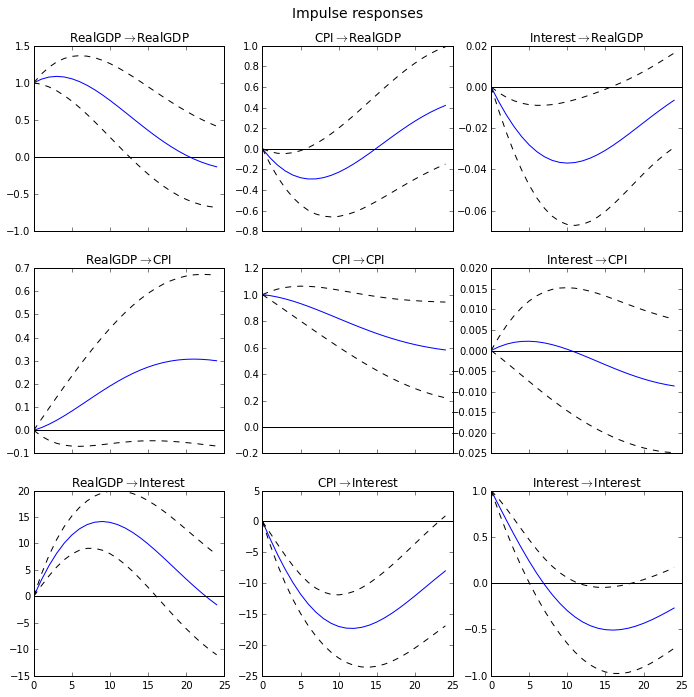

In [906]:
varmodel('Denmark')

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -12.72       -12.63    2.979e-06       -12.69
1        -22.45       -22.06    1.777e-10       -22.30
2        -23.16      -22.48*    8.749e-11      -22.89*
3        -23.21       -22.24   8.358e-11*       -22.83
4        -23.19       -21.93    8.586e-11       -22.69
5        -23.22       -21.66    8.489e-11       -22.60
6        -23.11       -21.27    9.572e-11       -22.38
7       -23.23*       -21.09    8.727e-11       -22.38
8        -23.05       -20.62    1.086e-10       -22.08
9        -23.16       -20.44    1.014e-10       -22.08
10       -23.13       -20.12    1.107e-10       -21.94
11       -23.02       -19.72    1.330e-10       -21.71
* Minimum



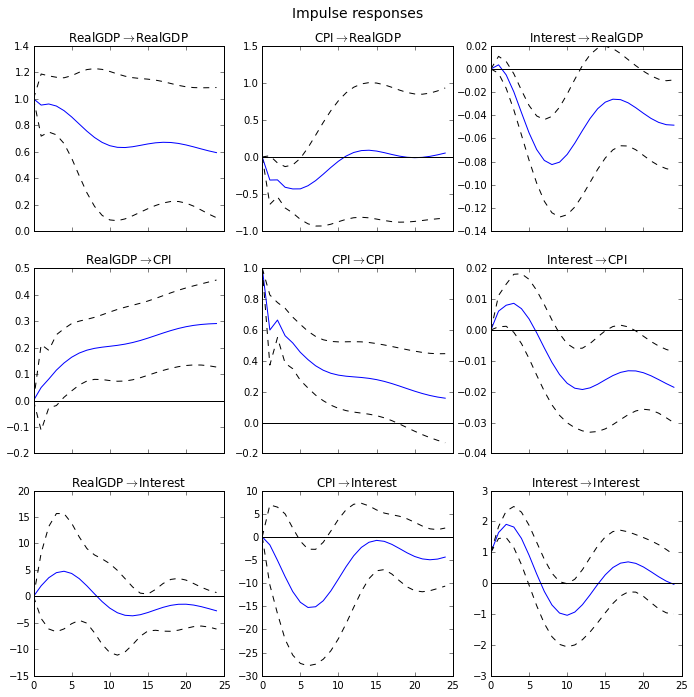

In [907]:
varmodel('Sweden')

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -11.63       -11.53    8.881e-06       -11.59
1        -23.52       -23.13    6.115e-11       -23.36
2        -25.46      -24.78*    8.779e-12       -25.19
3        -25.61       -24.64    7.587e-12       -25.23
4        -25.67       -24.40    7.234e-12       -25.16
5        -25.87       -24.31    5.978e-12       -25.25
6        -26.18       -24.33    4.472e-12       -25.44
7        -26.38       -24.25    3.735e-12       -25.53
8        -26.26       -23.83    4.389e-12       -25.29
9        -26.38       -23.66    4.057e-12       -25.30
10       -26.52       -23.51    3.739e-12       -25.32
11      -26.87*       -23.57   2.832e-12*      -25.56*
* Minimum



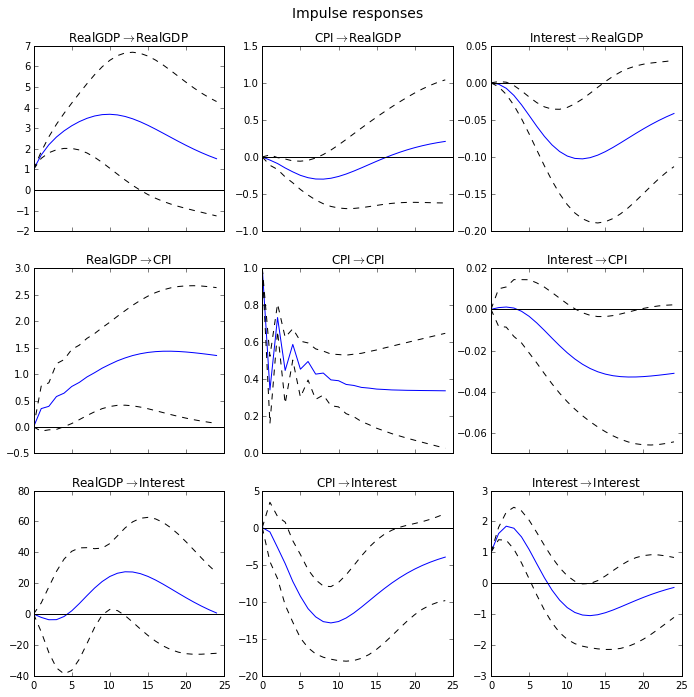

In [908]:
varmodel('Spain')

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -12.35       -12.25    4.351e-06       -12.31
1        -22.99       -22.60    1.041e-10       -22.83
2        -23.47      -22.79*    6.405e-11      -23.20*
3        -23.54       -22.57    6.003e-11       -23.16
4        -23.53       -22.27    6.108e-11       -23.03
5        -23.72       -22.17    5.123e-11       -23.10
6        -23.67       -21.82    5.509e-11       -22.93
7        -23.81       -21.67   4.907e-11*       -22.96
8        -23.81       -21.38    5.088e-11       -22.84
9       -23.87*       -21.15    5.005e-11       -22.79
10       -23.83       -20.82    5.477e-11       -22.64
11       -23.75       -20.44    6.442e-11       -22.44
* Minimum



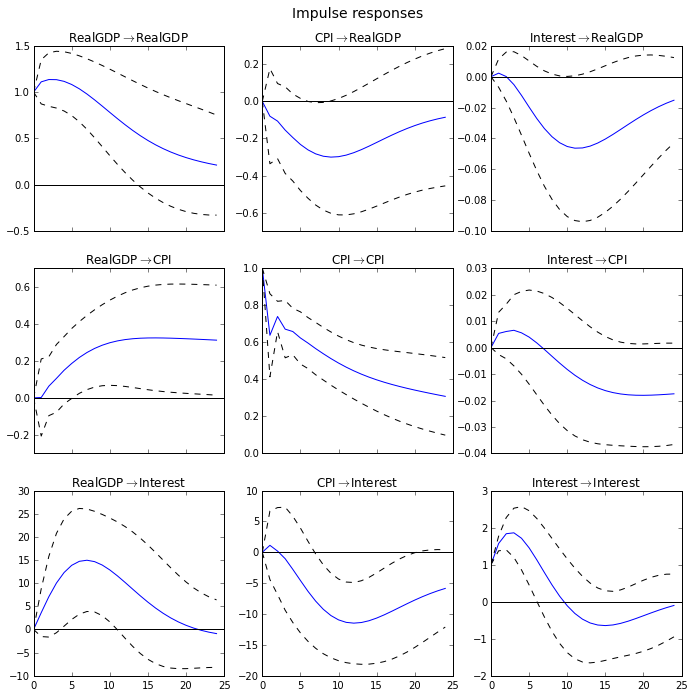

In [909]:
varmodel('Portugal')

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -14.18       -14.08    6.974e-07       -14.14
1        -24.37       -23.98    2.620e-11       -24.21
2       -25.02*      -24.35*   1.357e-11*      -24.76*
3        -24.90       -23.93    1.548e-11       -24.51
4        -24.80       -23.54    1.721e-11       -24.30
5        -24.77       -23.21    1.802e-11       -24.15
6        -24.76       -22.91    1.847e-11       -24.03
7        -24.72       -22.58    1.973e-11       -23.87
8        -24.67       -22.24    2.148e-11       -23.70
9        -24.72       -22.00    2.131e-11       -23.64
10       -24.76       -21.75    2.165e-11       -23.57
11       -24.87       -21.57    2.091e-11       -23.56
* Minimum



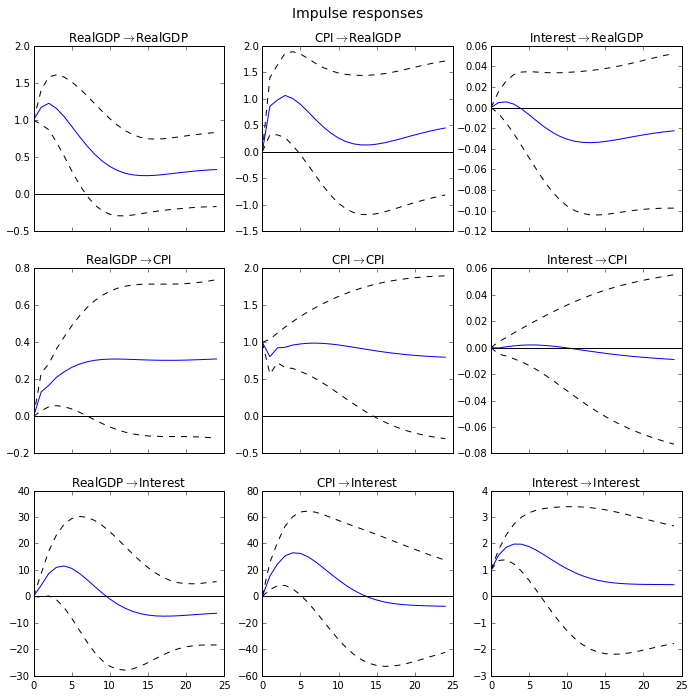

In [910]:
varmodel('Germany')

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -13.58       -13.48    1.261e-06       -13.54
1        -23.81       -23.41    4.552e-11       -23.65
2        -24.36      -23.66*    2.646e-11       -24.08
3        -24.36       -23.36    2.651e-11       -23.96
4        -24.27       -22.96    2.939e-11       -23.75
5        -24.76       -23.15    1.826e-11      -24.12*
6        -24.71       -22.80    1.954e-11       -23.96
7        -24.80       -22.59    1.843e-11       -23.93
8        -24.80       -22.29    1.924e-11       -23.81
9        -25.03       -22.22    1.617e-11       -23.92
10       -25.05       -21.94    1.694e-11       -23.83
11      -25.39*       -21.98   1.331e-11*       -24.04
* Minimum



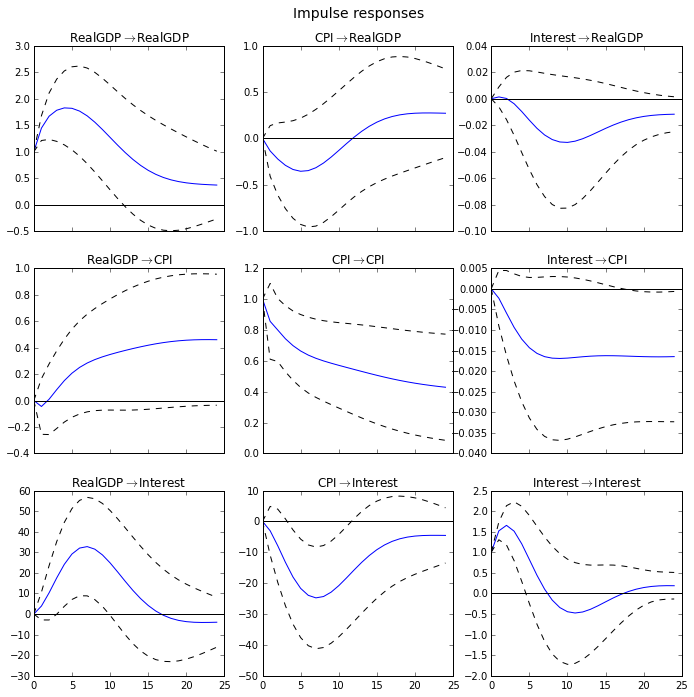

In [911]:
varmodel('Netherlands')

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -13.45       -13.35    1.447e-06       -13.41
1        -24.68       -24.29    1.919e-11       -24.52
2        -25.34      -24.66*    9.860e-12      -25.07*
3       -25.35*       -24.38   9.798e-12*       -24.97
4        -25.23       -23.97    1.117e-11       -24.73
5        -25.09       -23.53    1.307e-11       -24.47
6        -24.99       -23.15    1.460e-11       -24.26
7        -25.03       -22.89    1.448e-11       -24.18
8        -24.90       -22.47    1.708e-11       -23.93
9        -24.90       -22.18    1.782e-11       -23.82
10       -24.95       -21.94    1.789e-11       -23.76
11       -25.34       -22.04    1.305e-11       -24.03
* Minimum



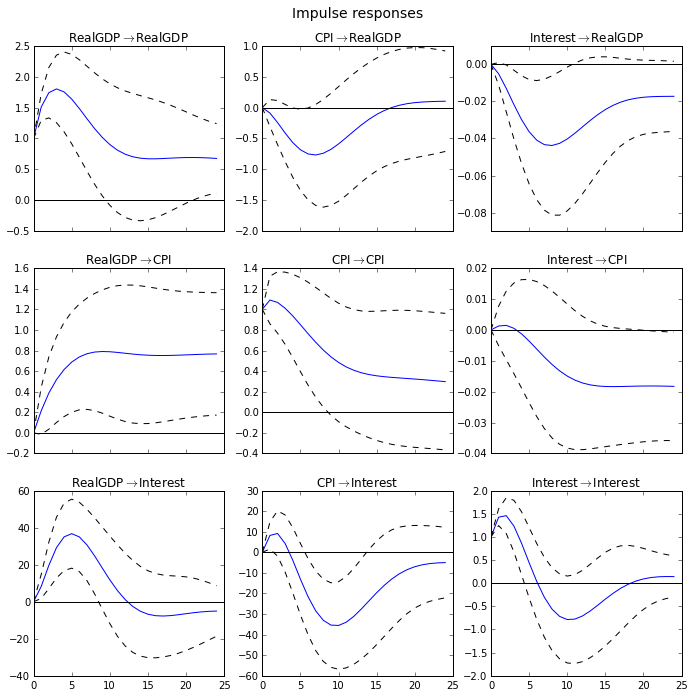

In [912]:
varmodel('Belgium')

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -14.30       -14.20    6.181e-07       -14.26
1        -23.92       -23.52    4.081e-11       -23.76
2        -24.34      -23.64*    2.692e-11      -24.06*
3        -24.26       -23.25    2.938e-11       -23.86
4        -24.10       -22.79    3.479e-11       -23.58
5        -24.21       -22.61    3.143e-11       -23.58
6        -24.31       -22.40    2.923e-11       -23.56
7        -24.24       -22.03    3.228e-11       -23.37
8        -24.08       -21.57    3.945e-11       -23.09
9        -24.32       -21.51    3.295e-11       -23.21
10       -24.57       -21.46    2.742e-11       -23.34
11      -24.74*       -21.33   2.546e-11*       -23.39
* Minimum



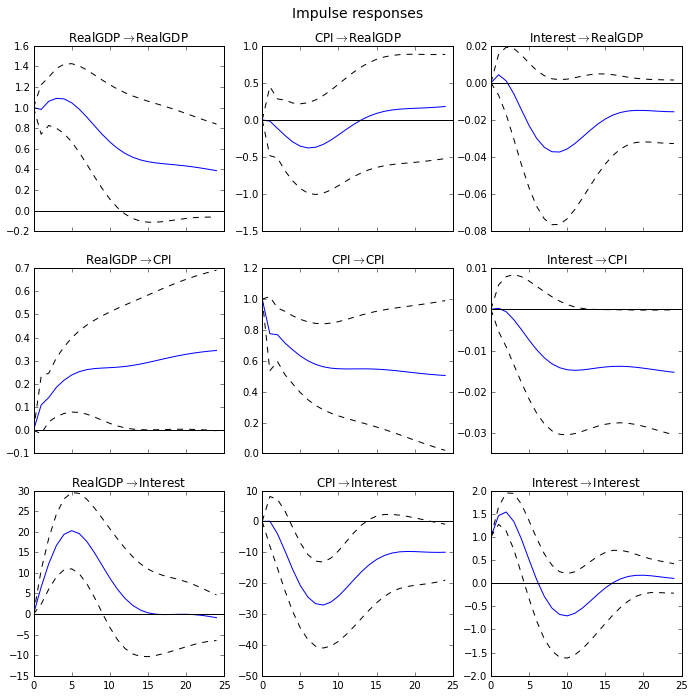

In [913]:
varmodel('Austria')

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -12.31       -12.21    4.514e-06       -12.27
1        -23.12       -22.73    9.122e-11       -22.96
2        -23.56      -22.88*    5.898e-11      -23.29*
3        -23.47       -22.50    6.473e-11       -23.08
4        -23.41       -22.15    6.880e-11       -22.91
5        -23.76       -22.20    4.937e-11       -23.14
6        -23.76       -21.92    4.998e-11       -23.03
7        -23.92       -21.78    4.376e-11       -23.07
8        -23.87       -21.44    4.761e-11       -22.91
9       -24.12*       -21.40   3.880e-11*       -23.04
10       -24.09       -21.08    4.249e-11       -22.89
11       -24.06       -20.75    4.734e-11       -22.74
* Minimum



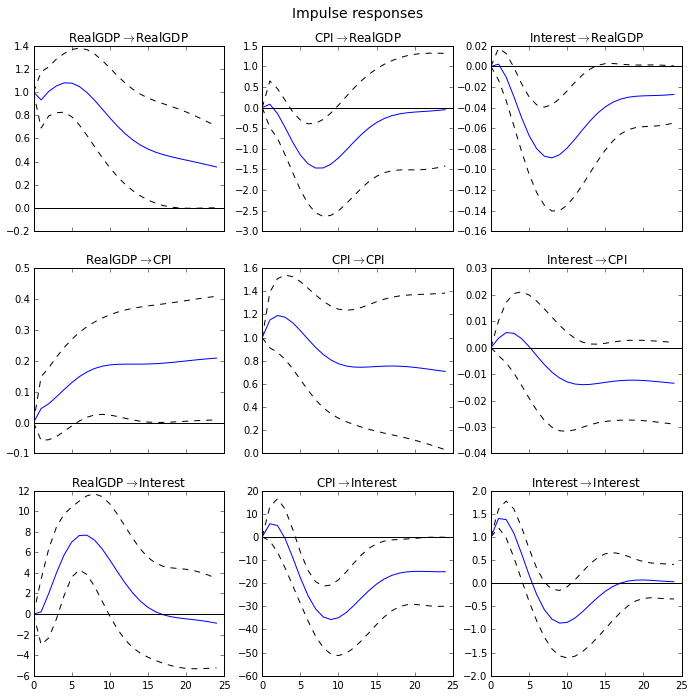

In [914]:
varmodel('Finland')

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -12.32       -12.22    4.457e-06       -12.28
1        -24.80       -24.42    1.689e-11       -24.65
2        -26.00      -25.32*    5.123e-12      -25.73*
3        -26.01       -25.04    5.084e-12       -25.63
4        -26.05       -24.79    4.931e-12       -25.55
5        -26.22       -24.67    4.200e-12       -25.61
6        -26.27       -24.42    4.092e-12       -25.53
7        -26.18       -24.04    4.576e-12       -25.33
8        -26.02       -23.59    5.552e-12       -25.06
9        -26.41       -23.69   3.948e-12*       -25.33
10       -26.41       -23.40    4.153e-12       -25.22
11      -26.53*       -23.23    3.977e-12       -25.22
* Minimum



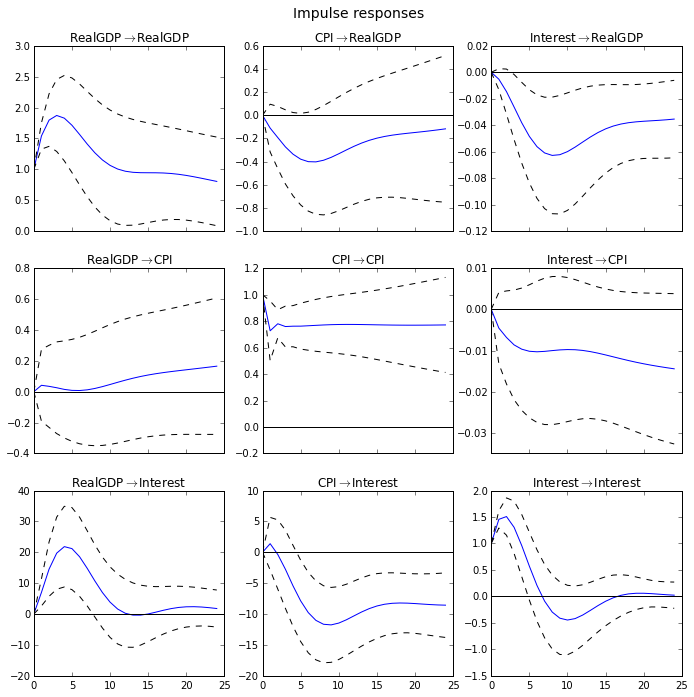

In [915]:
varmodel('United Kingdom')

##Conclusion

The specific ways in which the countries may be grouped may be less significant than the fact that the implementation of a single financial market and common monetary policy has significantly reduced the differences in the transmission of monetary policy among the countries. It is also notable that in addition to the narrowing of differences between countries, the figures themselves are much smaller. At the same time, most of the countries seem to experience a longer lasting effect from the transmission of monetary policy. 

Given the turbulence that the financial crisis has caused over the past few years, which may have been reflected in the results of this project, it can be assumed that the intended effect of a shared financial market and monetary policy has not been achieved quite yet. However, this provides the possibility for further research, which is made more interesting by the potential changes that may occur within the European Union in the near future. 

##Data Sources

Real GDP and exchange rate data were obtained through the FRED api for Python. Real GDP is in total GDP by expenditure in terms of national currency and is seasonally adjusted. Figures for Sweden, Spain, Portugal, and United Kingdom are in 2000 chained national currency. Exchange rates are averages of daily rates in terms of national currency to US dollar and are not seasonally adjusted.

[CPI](https://data.oecd.org/price/inflation-cpi.htm) and [short term interest rate](https://data.oecd.org/interest/short-term-interest-rates.htm) data were downloaded from the OECD website. CPI is for total items and Index 2010=1. Interest rates are total percentages per annum. 

All data is quarterly covering the period 1995:01 - 2014:04 with the exceptions of Austria, Italy, and the Netherlands for which there was incomplete Real GDP data so the data instead covers the period 1996:01 - 2014:04. 


####Citations: 

OECD (2015), Inflation (CPI) (indicator). doi: 10.1787/eee82e6e-en (Accessed on 06 August 2015)

OECD (2015), Short-term interest rates (indicator). doi: 10.1787/2cc37d77-en (Accessed on 06 August 2015)